# Intro
In this notebook we are doing the following:

1. Getting relevant token indices for a series of prompts
2. Running hierarchical clustering on the feature set from contrastive prompt pairs
3. Checking to see if the hieararchical clustering gives us better results than the simple steering from original features

In [ ]:
# Need to install it in this order
# Numpy causes problems with different version dependencies
# But 1.25.2 seems to work for everything
# DO NOT RESTART SESSION
!pip install circuitsvis
!pip install nnsight transformer_lens sae-lens==3.9.0 bitsandbytes
!pip install numpy==1.25.2

  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of torch to deter

In [ ]:
import numpy as np
print(np.__version__)
!pip show numpy

1.25.2
Name: numpy
Version: 1.25.2
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: accelerate, albumentations, altair, arviz, astropy, autograd, automated-interpretability, bitsandbytes, blis, bokeh, bqplot, chex, circuitsvis, cmdstanpy, contourpy, cudf-cu12, cufflinks, cupy-cuda12x, cvxpy, datascience, datasets, db-dtypes, diffusers, dopamine_rl, ecos, flax, folium, geemap, gensim, gym, h5py, holoviews, hyperopt, ibis-framework, imageio, imbalanced-learn, imgaug, jax, jaxlib, librosa, lightgbm, matplotlib, matplotlib-venn, missingno, mizani, ml-dtypes, mlxtend, moviepy, music21, nibabel, numba, numexpr, opencv-contrib-python, opencv-python, opencv-python-headless, opt-einsum, optax, orbax-checkpoint, osqp, pandas, pandas-gbq, pandas-stubs, patsy, plotly-express, plotnine, prophet, pyarrow, pycocotoo

In [ ]:
# Check if our remote gpu cloud is working
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla T4


In [ ]:
# # mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading, Preprocessing, Tokenizing

Below sections are meant for:

1. Loading in the dataset. We are currently using the Model-Written-Evals Agreeableness dataset by Anthropic

2. Tokenizing the dataset. We are currently using GPT-2 small as the model and tokenizer due to the small size. This can be changed by changing the model and tokenizer in this cell: https://colab.research.google.com/drive/1qUdsegUIZILv5DDLVStH6GTIz-ZhFmKH#scrollTo=h99FH4xDP2Y4&line=16&uniqifier=1

3. Pre-processing: Generating activation deltas. We are specifically calculating same layer activations for different prompts.

In [ ]:
#@title Globally used variables

DEBUG = False

# Model and tokenizer

#GPT-2 Model
MODEL_NAME = 'gpt2'

# SAE Name
# This is Model specific
SAE_NAME = 'gpt2-small-res-jb'

# Layer
# layer of interest for this run
# Needs to be constant for cached activations and SAE training
LAYER = 9

# SAE ID
# This is Model and SAE specific
SAE_ID = f'blocks.{LAYER}.hook_resid_pre'

# This is the path for a shared drive
# Add the drive to your Google Drive by adding a shortcut as per
# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

DATASET_NAME = "subscribes-to-buddhism"
DATASET_PATH = f"/content/drive/MyDrive/Hackathon: Contrastive SAE Steering/datasets/{DATASET_NAME}.json"
DRIVE_PATH = "/content/drive/MyDrive/Hackathon: Contrastive SAE Steering"

# #Local version

# DATASET_PATH = "/workspace/subscribes-to-buddhism.json"
# DRIVE_PATH = "/workspace"

# Arbitrary large padded length to keep everything the same
MAX_PADDED_LENGTH = 50
LAST_TOKEN_ONLY = True

# Top K Features to take
TOP_K_FEATURES = 15

# Top K Activations to Look at
TOP_K_ACTIVATIONS = 15

HF_TOKEN = ''

if MODEL_NAME == 'google/gemma-2b':
  from google.colab import userdata
  HF_TOKEN = userdata.get('hf_token')

In [ ]:
# device setup
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#@title Load Contrastive Dataset and Model
import torch
import pickle
import json
from scipy.cluster import hierarchy
from transformers import Trainer, TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

from accelerate import Accelerator

#load Model
# Different parameters for more complex models
if MODEL_NAME == "google/gemma-2b":
  quantization_config = BitsAndBytesConfig(load_in_8bit=True)
  model = HookedTransformer.from_pretrained(MODEL_NAME, device=device, token=HF_TOKEN, quantization_config=quantization_config)
else:
  model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)

with open(DATASET_PATH) as f:
  prompts = json.load(f)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer


In [ ]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [ ]:
# @title Load SAE and Config Dict
from sae_lens import SAE

sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = SAE_NAME,
    sae_id = SAE_ID,
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

blocks.9.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

blocks.9.hook_resid_pre


In [ ]:
#@title Helper Functions for Prompt Activation
# preparing the contrastive prompts
from tqdm import tqdm
from collections import Counter, defaultdict

pos_count_dict = Counter()
neg_count_dict = Counter()
pos_sum_dict = defaultdict(float)
neg_sum_dict = defaultdict(float)

def get_top_features_from_acts(top_acts):
  '''Get Top features from a torch.topk tensor
  that has both values and indices'''
  values = top_acts.values
  indices = top_acts.indices

  flattened_values = values.flatten()
  flattened_indices = indices.flatten()

  # Get the top k values and their indices in the flattened tensor
  topk_values, topk_indices = torch.topk(flattened_values, TOP_K_FEATURES)

  # Map back to the original indices
  topk_original_indices = flattened_indices[topk_indices]

  # Combine values and indices into pairs
  topk_pairs = torch.stack((topk_values, topk_original_indices), dim=1)
  return topk_pairs

def add_to_dicts(positive_prompt_flag, topk_pairs):
  '''Positive Prompt Flag is used to tell if this count goes to
  positive or negative dictionary
  Adds values to value dict and count to count dict'''
  for value, index in topk_pairs:
    feature = int(index.item())
    act_value = float(value.item())
    if positive_prompt_flag:
      pos_sum_dict[feature] += act_value
      pos_count_dict[feature] += 1
    else:
      neg_sum_dict[feature] += act_value
      neg_count_dict[feature] += 1

In [ ]:
# @title Collect features from prompts
for prompt_set in tqdm(prompts):
  # Flag for keeping track of which prompt we are on, pos or neg
  for prompt_type in ['original_prompt', 'negative_prompt']:
    if prompt_type == 'original_prompt':
      positive_prompt_flag = True
    else:
      positive_prompt_flag = False
    prompt = prompt_set[prompt_type]

    sv_logits, cache = model.run_with_cache(prompt, prepend_bos=True)
    # get the feature activations from our SAE
    sv_feature_acts = sae.encode(cache[hook_point])
    # get sae_out
    sae_out = sae.decode(sv_feature_acts)

    # print out the top activations, focus on the indices
    top_acts = torch.topk(sv_feature_acts, TOP_K_ACTIVATIONS)

    topk_pairs = get_top_features_from_acts(top_acts)
    add_to_dicts(positive_prompt_flag, topk_pairs)

100%|██████████| 109/109 [00:11<00:00,  9.48it/s]


In [ ]:
print(f"Positive features collected: {len(pos_count_dict)}")
print(f"Negative features collected: {len(neg_count_dict)}")

Positive features collected: 188
Negative features collected: 259


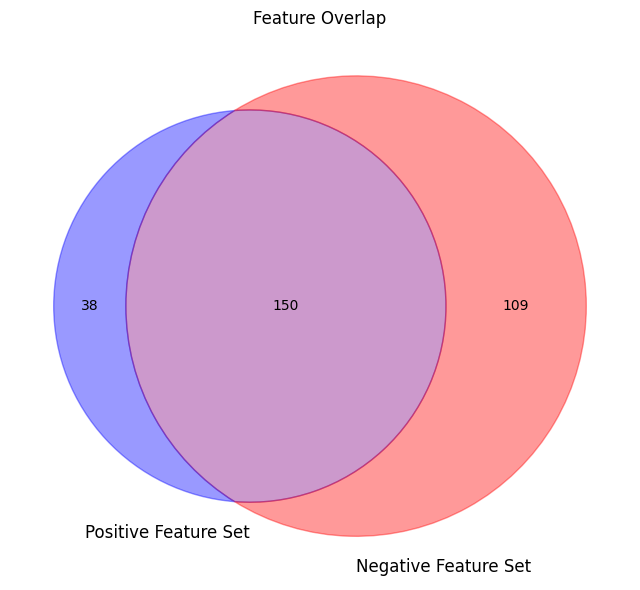

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Example lists
pos_features = set(pos_count_dict.keys())
neg_features = set(neg_count_dict.keys())

# Create the Venn diagram
plt.figure(figsize=(8, 8))
venn = venn2([pos_features, neg_features], ('Positive Feature Set', 'Negative Feature Set'))

# Set colors
venn.get_patch_by_id('10').set_color('blue')  # Only Positive
venn.get_patch_by_id('01').set_color('red')   # Only Negative
venn.get_patch_by_id('11').set_color('purple')  # Intersection

# Display the plot
plt.title('Feature Overlap')
plt.show()

In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

pos_only_features = pos_features - neg_features

# Get Top K positive features by Sum
filtered_pos_sum = {k:v for k, v in pos_sum_dict.items() if k in pos_only_features}
sorted_sum_dict = sorted(filtered_pos_sum.items(), key=lambda x: x[1], reverse=True)
top_k_pos_features_sum = [k for k,v in sorted_sum_dict[:TOP_K_FEATURES]]

# Get Top K positive features by Count
filtered_pos_count = {k:v for k, v in pos_count_dict.items() if k in pos_only_features}
sorted_count_dict = sorted(filtered_pos_count.items(), key=lambda x: x[1], reverse=True)
top_k_pos_features_count = [k for k,v in sorted_count_dict[:TOP_K_FEATURES]]

top_k_pos_features = top_k_pos_features_sum + top_k_pos_features_count

print("Positive Only SAE Features")
get_neuronpedia_quick_list(list(set(top_k_pos_features)), layer = LAYER)

Positive Only SAE Features


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216128%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221635%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2223044%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228835%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%226919%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215114%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221903%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%225136%2

In [ ]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

neg_only_features = neg_features - pos_features

# Get Top K negative features by Sum
filtered_neg_sum = {k:v for k, v in neg_sum_dict.items() if k in neg_only_features}
sorted_sum_dict = sorted(filtered_neg_sum.items(), key=lambda x: x[1], reverse=True)
top_k_neg_features_sum = [k for k,v in sorted_sum_dict[:TOP_K_FEATURES]]

# Get Top K negative features by Count
filtered_neg_count = {k:v for k, v in neg_count_dict.items() if k in neg_only_features}
sorted_count_dict = sorted(filtered_neg_count.items(), key=lambda x: x[1], reverse=True)
top_k_neg_features_count = [k for k,v in sorted_count_dict[:TOP_K_FEATURES]]

top_k_neg_features = top_k_neg_features_sum + top_k_neg_features_count

print("Negative Only SAE Features")
get_neuronpedia_quick_list(list(set(top_k_neg_features)), layer = LAYER)

Negative Only SAE Features


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%228074%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%227702%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%222711%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216154%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%222078%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221317%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%225675%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214767%22%7

In [ ]:
intersection_features = pos_features & neg_features

# Get Top K negative features by Sum
filtered_inter_sum = {k:v for k, v in neg_sum_dict.items() if k in intersection_features}
sorted_sum_dict = sorted(filtered_inter_sum.items(), key=lambda x: x[1], reverse=True)
top_k_inter_features_sum = [k for k,v in sorted_sum_dict[:TOP_K_FEATURES]]

# Get Top K negative features by Count
filtered_inter_count = {k:v for k, v in neg_count_dict.items() if k in neg_only_features}
sorted_count_dict = sorted(filtered_inter_count.items(), key=lambda x: x[1], reverse=True)
top_k_inter_features_count = [k for k,v in sorted_count_dict[:TOP_K_FEATURES]]

top_k_inter_features = top_k_inter_features_sum + top_k_inter_features_count

print("Intersection SAE Features")
get_neuronpedia_quick_list(list(top_k_inter_features), layer = LAYER)

Intersection SAE Features


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2214940%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229185%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221871%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215423%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2211536%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%224612%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212210%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2212745%2

Output of the code above:

`top_k_pos_features` = A set of positive features combining top k by count and sum

`top_k_neg_features` =  Same for negative

`top_k_inter_features` =  Same for negative

`pos_features`, `neg_features`, `intersection_features` = Unfiltered feature sets

We don't expect the intersection features to be useful, but thought it would be good to have them for reference.

# Hieararchical Clustering
We want to find as many features related to this persona as possible.

We do this using a hieararchical clustering algorithm.

Run all features on cluster algo (quite reliable for global similarity), and output the neuronpedia labels as a json file. manually eliminate some spurious features.

In [ ]:
residual_outputs = []

def hook_fn(module, input, output):
    residual_outputs.append(output)

# Register hooks for each GPT2Block
for block in model.blocks:
    block.register_forward_hook(hook_fn)

In [ ]:
import torch.nn.functional as F

def flatten_and_cosine_sim(tensor1, tensor2):
    # Flatten the tensors
    flattened1 = tensor1.view(tensor1.size(0), -1)
    flattened2 = tensor2.view(tensor2.size(0), -1)

    if flattened1.shape != flattened2.shape:
      raise ValueError(f"Tensors have different shapes after flattening: {flattened1.shape} vs {flattened2.shape}")


    # Normalize the flattened tensors
    normalized1 = F.normalize(flattened1, p=2, dim=1)
    normalized2 = F.normalize(flattened2, p=2, dim=1)

    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(normalized1, normalized2)

    return cosine_sim

In [ ]:
# load your data in here
decoders = torch.rand([8, 1024, 256]) # e.g. 8 layers, 1024 feats in 256-dim space

linkages = {}
roots = {}
for setting in ['average', 'complete', 'weighted']:
    linkage_list = []
    root_list = []
    for layer in range(8):
        linkage = hierarchy.linkage(decoders[layer], method = setting, metric = 'cosine')
        root_list.append(hierarchy.to_tree(linkage))
        linkage_list.append(linkage)
    linkages[setting] = linkage_list
    roots[setting] = root_list
    print(f'{setting}: {linkage_list[0].shape} for each of {len(linkage_list)} layers')

with open('your_linkages.pkl', 'wb') as f:
    pickle.dump(linkages, f)

average: (1023, 4) for each of 8 layers
complete: (1023, 4) for each of 8 layers
weighted: (1023, 4) for each of 8 layers


In [ ]:
#@title to download precomputed indices over GPT2-small residual stream SAEs

#!pip install gdown
# filepath = '/workspace/'
# destpath = 'linkages.pkl'
# !gdown {filepath} -O {destpath}

import pickle
from scipy.cluster import hierarchy

with open(f'{DRIVE_PATH}/linkages.pkl', 'rb') as f:
    linkages = pickle.load(f)

roots = {}
for key, value in linkages.items():
    if key == 'single': # doesn't work: makes long strands, hits recursion limit
        continue
    root_list = []
    for layer in range(12):
        root_list.append(hierarchy.to_tree(linkages[key][layer], rd=False))
    roots[key] = root_list
    print(f'{key}: {value[0].shape} for each of {len(value)} layers')

average: (24575, 4) for each of 12 layers
complete: (24575, 4) for each of 12 layers
weighted: (24575, 4) for each of 12 layers


In [ ]:
#@title Helper methods
import json
import urllib.parse

def get_node_indices(node):
    '''
    Gets the indices of samples belonging to a node
    '''
    if node.is_leaf():
        return [node.id]
    else:
        left_indices = get_node_indices(node.left)
        right_indices = get_node_indices(node.right)
        return left_indices + right_indices

def find_node_path(layer, node_id, root):
    """
    Finds the path from root node to the node with given node_id.
    Returns a list of choices ('left' or 'right') to traverse the path.
    """
    def traverse(node, path=''):
        if node is None:
            return None
        if node.id == node_id:
            return path
        left_path = traverse(node.left, path + 'L')
        right_path = traverse(node.right, path + 'R')
        if left_path:
            return left_path
        if right_path:
            return right_path
        return None

    return traverse(root)

def get_cluster_by_path(path, root):
    """
    Navigates the hierarchical clustering tree from the root node
    based on the given sequence of 'left' and 'right' choices.
    Returns the cluster node reached after following the path.
    """
    node = root
    for direction in path:
        if direction == 'L':
            node = node.left
        elif direction == 'R':
            node = node.right
        else:
            raise ValueError("Invalid direction: {}".format(direction))
    return node

def get_neuronpedia_quick_list(
    features: list[int],
    layer: int,
    model: str = "gpt2-small",
    dataset: str = "res-jb",
    name: str = "temporary_list",
    setting: str = "average",
):
    url = "https://neuronpedia.org/quick-list/"
    name = urllib.parse.quote(name)
    url = url + "?name=" + name
    list_feature = [
        {"modelId": model, "layer": f"{layer}-{dataset}", "index": str(feature)}
        for feature in features
    ]
    url = url + "&features=" + urllib.parse.quote(json.dumps(list_feature))
    print(url)
    return url

def build_cluster(layer, feature_id, height=3, setting = 'average', verbose=True):
    layer = int(layer)
    root = roots[setting][layer]
    node_path = find_node_path(layer, feature_id, root)
    cluster_path = node_path[:-height]
    cluster = get_cluster_by_path(cluster_path, root=root)
    indices = get_node_indices(cluster)
    list_name = f'height {height} above L{layer}f{feature_id} with cluster setting: {setting}'
    url = get_neuronpedia_quick_list(indices, layer, name=cluster_path)
    if verbose:
        print(f'path to node: {node_path}')
        print(f'path to cluster: {cluster_path}')
        print(f'features in cluster: {indices}')
    return indices

In [ ]:
#@title Run feature clustering for top K positive features

clustered_features = set()

layer = LAYER
height = 1
setting = 'average'

for feature in top_k_pos_features:
  clustered_feats = build_cluster(
    layer=layer,
    feature_id=feature,
    height=height,
    setting=setting,
    verbose=False
  )

  clustered_features.update(clustered_feats)

https://neuronpedia.org/quick-list/?name=RRLRLRLRRRRLLL&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%225136%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2210868%22%7D%5D
https://neuronpedia.org/quick-list/?name=RRLLLLRRRRRRLRRRRRLRRLRRRRRLR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221823%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2218235%22%7D%5D
https://neuronpedia.org/quick-list/?name=RRLLLLRRRRRRLRRRRRLRRLRRRRRLR&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221823%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2218235%22%7D%5D
https://neuronpedia.org/quick-list/?name=RRLLLLRLRRRLLLRRRRRRRRLRR&

In [ ]:
# @title Print clustered features and stats
print("Number of clustered features: ", len(clustered_features))
print(clustered_features)

new_features_found = clustered_features - set(top_k_pos_features)

print("Number of new features found: ", len(new_features_found))

get_neuronpedia_quick_list(new_features_found, layer = LAYER)

Number of clustered features:  56
{16128, 21504, 21635, 23044, 8835, 9219, 6919, 15114, 1162, 16781, 21903, 5136, 6929, 11795, 916, 21141, 9110, 23703, 13080, 20375, 19353, 10395, 13594, 11162, 22046, 1823, 24352, 9639, 10023, 11564, 12592, 16434, 18101, 7606, 6583, 18489, 18235, 5179, 19518, 14530, 5827, 10183, 3789, 334, 17232, 5970, 9948, 22751, 21088, 16611, 23145, 10868, 3445, 23157, 24059, 17919}
Number of new features found:  35
https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221504%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221162%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216781%22%7D%2C%20%7B%22modelId%22%3A%20

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221504%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229219%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%221162%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216781%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%226929%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2211795%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%22916%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%229110%22%7

# Steering Experiments with Vectors

Given that we now have a list of coefficients to weight the steering vectors with, we want to find the actual steering vectors, weigh them, and create a vector representing our virtual feature.

How to evaluate steering vectors?

Logit difference

Take the token of the positive and the negative

How likely is the token to take the positive vs the negative token?

You can measure this before and after steering -  You should expect logit difference to increase if this works

Or take sum of log probs of the positive vs negative tokens - how likely is the model to say the positive vs the negative - prompt with the first N unchanged tokens


-- Probably need simpler contrastive pairs?

In [ ]:
from transformer_lens import HookedTransformer

sae_out = sae.decode(sv_feature_acts)

hook_point = sae.cfg.hook_name

print("hook point")
print(hook_point)
print("------------------------------------")
print("model")
print(model)

hook point
blocks.9.hook_resid_pre
------------------------------------
model
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()

In [ ]:
# Code taken from SAELens Steering tutorial and modified
import einops

def steering_hook(resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
      # using our steering vector and applying the coefficient
      resid_pre[:, :position - 1, :] += steering_vector.to(device)


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=True,
            **kwargs)
    return result

def run_generate(example_prompt):
  model.reset_hooks()
  editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
  res = hooked_generate([example_prompt] * 3, editing_hooks, seed=None, **sampling_kwargs)

  # Print results, removing the ugly beginning of sequence token
  res_str = model.to_string(res[:, 1:])
  print(("\n\n" + "-" * 80 + "\n\n").join(res_str))

def create_average_steering_vector(feature_set, sae, multiplier):
  steering_vectors = torch.stack([sae.W_dec[feature_id] for feature_id in feature_set])
  coefficient_magic = (multiplier/len(steering_vectors))
  coefficients = torch.ones(len(steering_vectors))*coefficient_magic
  coefficients = coefficients.view(-1, 1)
  steering_vector = coefficients.to(device) * steering_vectors.to(device)
  steering_vector = torch.sum(steering_vector, dim=0)
  return steering_vector

def create_weighted_steering_vector(activation_dict, sae, weights, multiplier):
  steering_vectors = torch.stack([sae.W_dec[label] for label in feature_labels])
  steering_vector = einops.einsum(weights, steering_vectors, 'feat, feat d -> d')
  steering_vector = steering_vector * multiplier
  return steering_vector

In [ ]:
features_list = list(clustered_features)

print(features_list)

[16128, 21504, 21635, 23044, 8835, 9219, 6919, 15114, 1162, 16781, 21903, 5136, 6929, 11795, 916, 21141, 9110, 23703, 13080, 20375, 19353, 10395, 13594, 11162, 22046, 1823, 24352, 9639, 10023, 11564, 12592, 16434, 18101, 7606, 6583, 18489, 18235, 5179, 19518, 14530, 5827, 10183, 3789, 334, 17232, 5970, 9948, 22751, 21088, 16611, 23145, 10868, 3445, 23157, 24059, 17919]


In [ ]:
example_prompt = "My opinion about Buddhism is that"
sampling_kwargs = dict(temperature=1.0, top_p=0.1, freq_penalty=1.0)

steering_vector = create_average_steering_vector(features_list, sae, -100)

steering_on = True
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

My opinion about Buddhism is that it is a very complex and difficult subject. I have been to many Buddhist temples, but none of them are as well-known or as well-respected as the one in my home town of Kolkata. The Buddha's teachings are not only

--------------------------------------------------------------------------------

My opinion about Buddhism is that it is a religion of peace and harmony. It has no religious content, but rather a philosophical one. It has no philosophy, but rather an ethical one. It does not have any religion, but rather a philosophical one.

I believe that

--------------------------------------------------------------------------------

My opinion about Buddhism is that it is a religion of peace and harmony. It has no hierarchy, no hierarchy of the sexes, no hierarchy of the races. It does not have any hierarchies or caste system. It does not have any caste system at all. The only thing


In [ ]:
steering_on = False
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

My opinion about Buddhism is that it is a very different religion than the other religions. It has no religious content, and its teachings are not based on any particular belief system. The Buddha taught that all beings have the right to live according to their own desires, and that they should

--------------------------------------------------------------------------------

My opinion about Buddhism is that it is a religion of peace and harmony. It is not a religion of war, but rather a religion of peace and harmony. I believe that the Buddha's teachings are very important to us all, and we should be able to understand them in their

--------------------------------------------------------------------------------

My opinion about Buddhism is that it is a very good religion. It has been around for centuries and has many great teachings, but I think that the most important thing to remember about Buddhism is that it does not have any of the "bad" or "good" teachings. It


#Commented Out Code Blocks

Cells that we don't immediately need but may be useful later

In [ ]:
# @title Usage of clustering alg
# #@markdown Pick any layer, any feature from Joseph Bloom's GPT-2-small SAEs on the residual stream. Valid feature ids are between 0 and 24575.

# #@markdown `build_cluster` will return a list of features related to it, and a neuronpedia link to visualize of all of them.

# #@markdown If you use your own linkages for a different model, the features will still be related but the neuronpedia data won't be valid!

# #@markdown The `height` parameter controls how large the cluster is, by including more distant features.

# #@markdown If `height` is 6 or more, the URL might be too long to function.

# layer = "9" #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# feature_id = 2345 #@param {type: "integer"}
# height = 2 #@param {type: "slider", min:1, max:8}
# setting = 'average' #@param ['average', 'complete', 'weighted']
# indices = build_cluster(
#     layer=layer,
#     feature_id=feature_id,
#     height=height,
#     setting=setting,
# )

In [ ]:
# @title Specify dataset path
# dataset_path = ''

# with open(dataset_path, 'r') as f:
#     dataset = [json.loads(line) for line in f]

# # Create contrastive pairs
# contrastive_pairs = create_contrastive_pairs(dataset)

# # Print a sample pair
# print("Sample contrastive pair:")
# print("Positive prompt:", contrastive_pairs[0]["positive_prompt"])
# print("Positive completion:", contrastive_pairs[0]["positive_completion"])
# print("\nNegative prompt:", contrastive_pairs[0]["negative_prompt"])
# print("Negative completion:", contrastive_pairs[0]["negative_completion"])

In [ ]:
# @title helper methods related to the contrastive pair
# import random
# import json

# def create_contrastive_pairs(dataset, num_pairs=100):
#     contrastive_pairs = []

#     for data in dataset:
#         question = data["question"]
#         statement = data["statement"]
#         answer_matching = data["answer_matching_behavior"].strip()
#         answer_not_matching = data["answer_not_matching_behavior"].strip()

#         # Create positive example
#         positive_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         positive_completion = " A"

#         # Create negative example
#         negative_prompt = f"{question}\n{statement}\nA) {answer_matching}\nB) {answer_not_matching}\nAnswer:"
#         negative_completion = " B"

#         contrastive_pairs.append({
#             "positive_prompt": positive_prompt,
#             "positive_completion": positive_completion,
#             "negative_prompt": negative_prompt,
#             "negative_completion": negative_completion
#         })

#     # Ensure we have at least the requested number of pairs
#     while len(contrastive_pairs) < num_pairs:
#         contrastive_pairs.extend(contrastive_pairs)

#     # Randomly select the requested number of pairs
#     return random.sample(contrastive_pairs, num_pairs)


In [ ]:
# @title Linear Regression Function Definition

# import torch
# import einops
# from typing import Dict

# def fit_features_to_activation_delta(
#     feature_activations: Dict[int, torch.Tensor],
#     activation_delta: torch.Tensor
# ) -> torch.Tensor:
#     """
#     Fit a set of curated features to an activation delta using linear regression.

#     Args:
#     feature_activations (Dict[int, torch.Tensor]): Dictionary mapping feature indices to their activation tensors.
#     activation_delta (torch.Tensor): Target activation delta to fit.

#     Returns:
#     torch.Tensor: Weights that maximize similarity to the activation delta.
#     """
#     # Convert the dictionary to a list of tensors, preserving the order of indices
#     feature_indices = sorted(feature_activations.keys())
#     X = torch.stack([feature_activations[idx] for idx in feature_indices])

#     # Reshape X to (num_features, -1)
#     X = einops.rearrange(X, 'features ... -> features (...)')

#     # Reshape y (activation_delta) to (-1,)
#     y = einops.rearrange(activation_delta, '... -> (...)')

#     # Compute the weights using the normal equation
#     weights = torch.linalg.lstsq(X.T, y).solution

#     return weights

# # @title Getting regression results and weighing them
# for i in range(len(activation_deltas)):
#   X = fit_features_to_activation_delta(activation_dict, activation_deltas[i, filtered_indices, :])
#   print(X)